# Imports

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import config as cfg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Loading the datasets

In [107]:
# Load a DataFrame from a pickle file
df_house = pd.read_pickle(cfg.PICKLE_HOUSE)
df_block = pd.read_pickle(cfg.PICKLE_BLOCK)

# Display the first few rows of the DataFrame
print(df_block.head())
print(df_house.head())

   block_number        day  energy_mean  DOY  day_of_week  is_holiday
0             0 2011-12-03     0.300233  337            5       False
1             0 2011-12-04     0.432563  338            6        True
2             0 2011-12-05     0.125417  339            0       False
3             0 2011-12-06     0.277542  340            1       False
4             0 2011-12-07     0.188792  341            2       False
       LCLid        day  energy_mean  block_number  DOY  day_of_week  \
0  MAC000246 2011-12-03     0.300233             0  337            5   
1  MAC000246 2011-12-04     0.432563             0  338            6   
2  MAC000246 2011-12-05     0.125417             0  339            0   
3  MAC000246 2011-12-06     0.277542             0  340            1   
4  MAC000246 2011-12-07     0.188792             0  341            2   

   is_holiday  
0       False  
1        True  
2       False  
3       False  
4       False  


# Pearson Correlation between Blocks

$$ \rho_{X, Y}=\frac{\text{cov}(X, Y)}{\sigma_X\sigma_Y} $$
$$ \text{cov}(X, Y): \text{Covariance} $$
$$\sigma:\text{standard deviation}$$

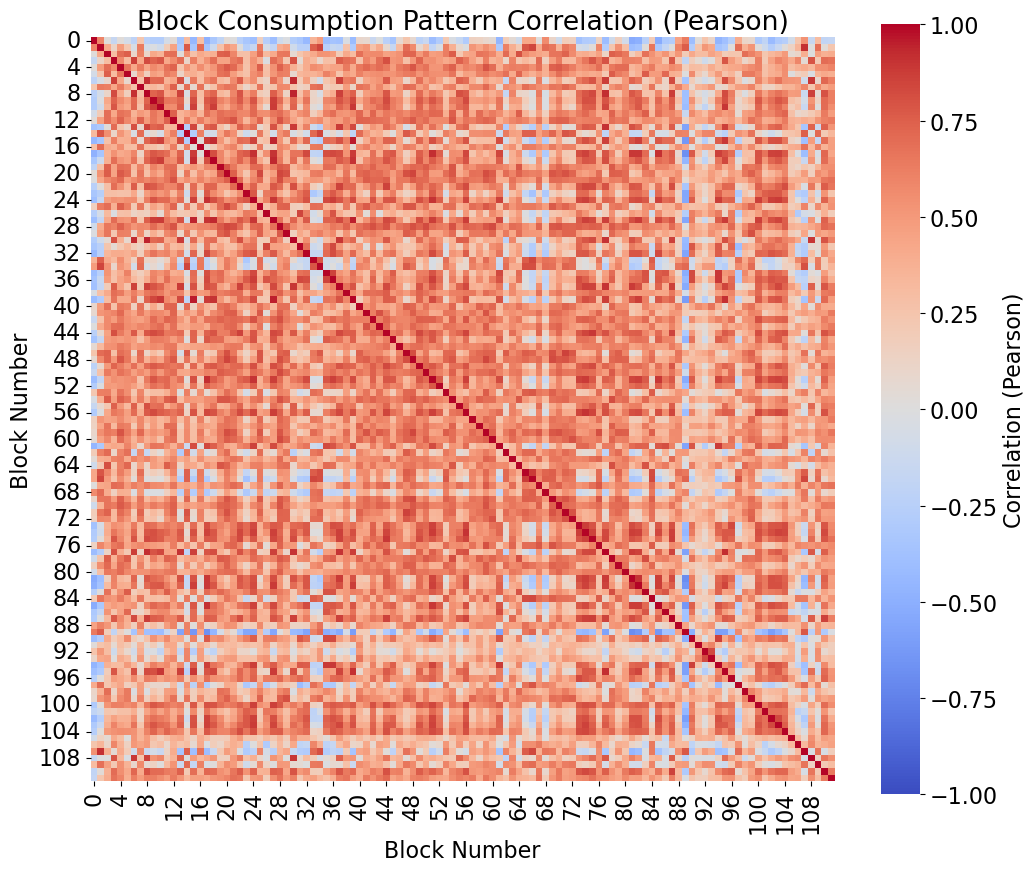

In [108]:
# pivot table: rows=day, cols=block_number, values=energy_mean
pivot = df_block.pivot(index="day", columns="block_number", values="energy_mean")

pivot = pivot.ffill().bfill()

# compute correlation matrix between blocks
corr_matrix = pivot.corr()

plt.rcParams.update({'font.size': 16})

# plot heatmap with fixed range from -1 to 1
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    center=0,
    square=True,
    vmin=-1, vmax=1,  # fixed range
    cbar_kws={"label": "Correlation (Pearson)"},
    cmap="coolwarm"  # optional: clearer for diverging values
)
plt.title("Block Consumption Pattern Correlation (Pearson)")
plt.xlabel("Block Number")
plt.ylabel("Block Number")
plt.show()

There is not much strong correlation between blocks, so each blocks requires a separate model train on its own data.
# Energy Consumption of Hauses vs Time

In [109]:
def plot_block_vs_houses(block_id, df_block, df_house):
    # get block-level curve
    block_curve = df_block[df_block["block_number"] == block_id]

    # get houses in this block
    house_curves = df_house[df_house["block_number"] == block_id]

    plt.figure(figsize=(14, 6))

    # plot each house curve
    for lid, house in house_curves.groupby("LCLid"):
        plt.plot(house["day"], house["energy_mean"], alpha=0.3, linewidth=1, label=f"House {lid}" if lid == house_curves["LCLid"].iloc[0] else "")

    # plot block curve on top
    plt.plot(block_curve["day"], block_curve["energy_mean"], color="black", linewidth=2, label=f"Block {block_id} mean")

    plt.legend()
    plt.title(f"Energy Consumption Variability in Block {block_id}")
    plt.xlabel("Day")
    plt.ylabel("Energy Mean")
    plt.show()


In [110]:
filtered_block = 25

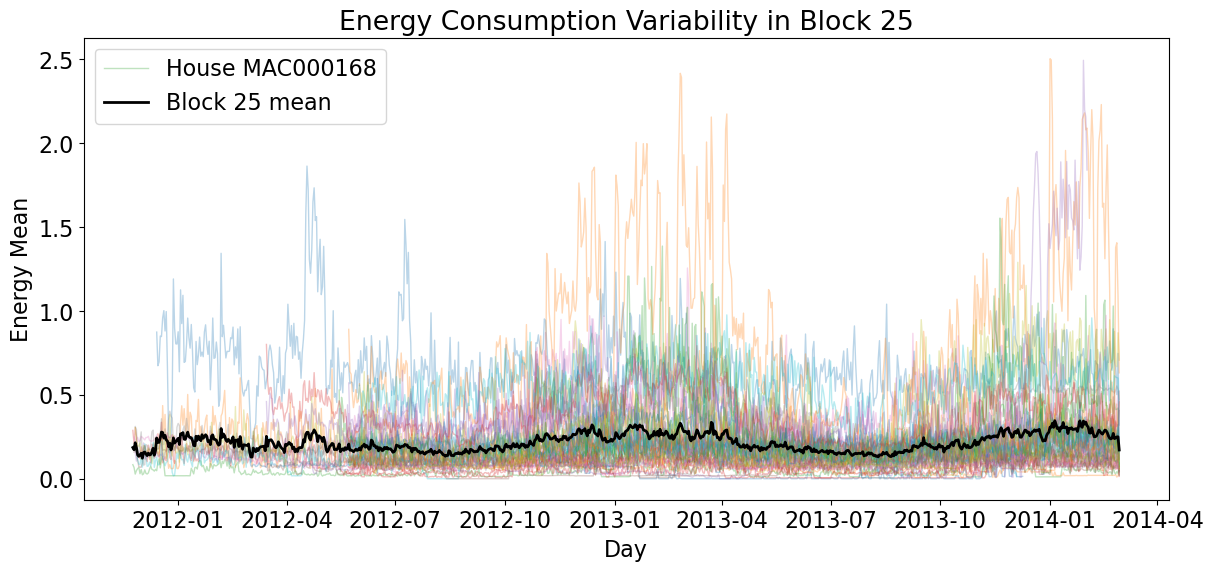

In [111]:
plot_block_vs_houses(filtered_block, df_block, df_house)

There is also a high variation in the Houses data so here too individual models are required.
# Effect of Day of the Year

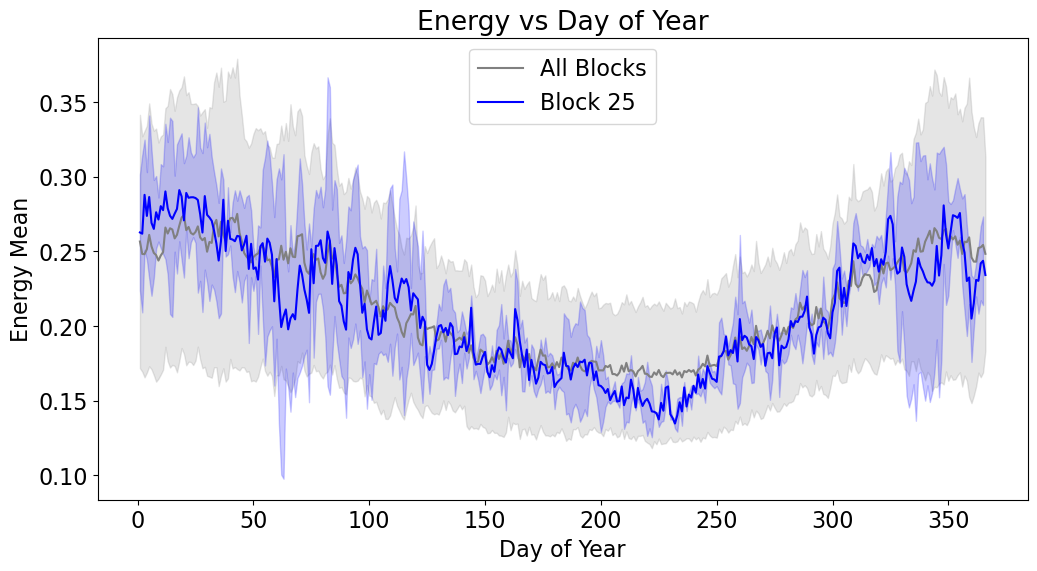

In [112]:
plt.figure(figsize=(12,6))

# Plot for all blocks
sns.lineplot(data=df_block, x="DOY", y="energy_mean", errorbar="sd", label="All Blocks", color="gray")

# Plot for block 
sns.lineplot(data=df_block[df_block["block_number"] == filtered_block], x="DOY", y="energy_mean", errorbar="sd", label=f"Block {filtered_block}", color="blue")

plt.title("Energy vs Day of Year")
plt.xlabel("Day of Year")
plt.ylabel("Energy Mean")
plt.legend()
plt.show()

A general pattern exists, lower energy consumption during summer (days 152 to 243) and higher consumption during winter (days 335 to 365 and 1 to 60)
# Effect of Day of the Week

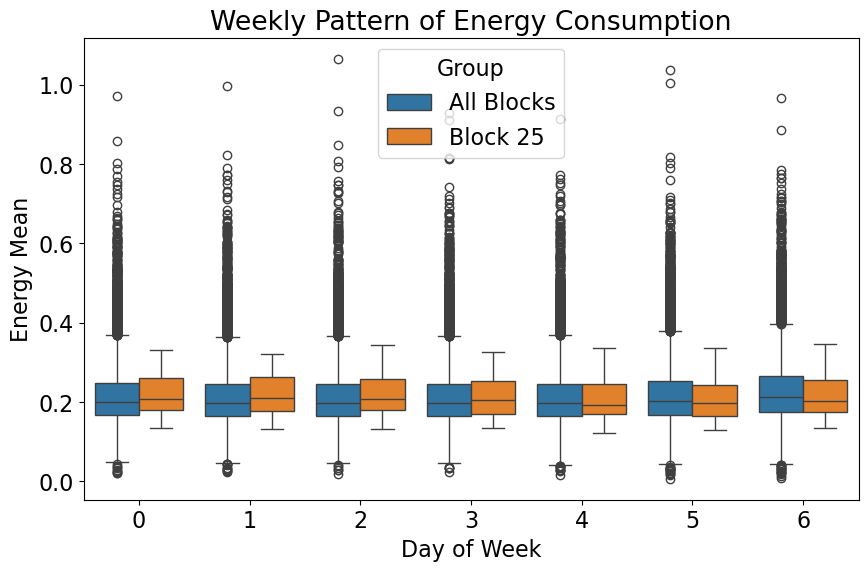

In [113]:
plt.figure(figsize=(10,6))

# Combine both datasets with a new column to distinguish them
df_block["Group"] = "All Blocks"
df_filtered = df_block[df_block["block_number"] == filtered_block].copy()
df_filtered["Group"] = f"Block {filtered_block}"

# Concatenate the two datasets
df_combined = pd.concat([df_block, df_filtered])

# Plot with hue to distinguish groups
sns.boxplot(data=df_combined, x="day_of_week", y="energy_mean", hue="Group")

plt.title("Weekly Pattern of Energy Consumption")
plt.xlabel("Day of Week")
plt.ylabel("Energy Mean")
plt.legend(title="Group")
plt.show()

The consumption rates are fairly similar, day of the week appears to contain no useful information.
# Effect of Holidays

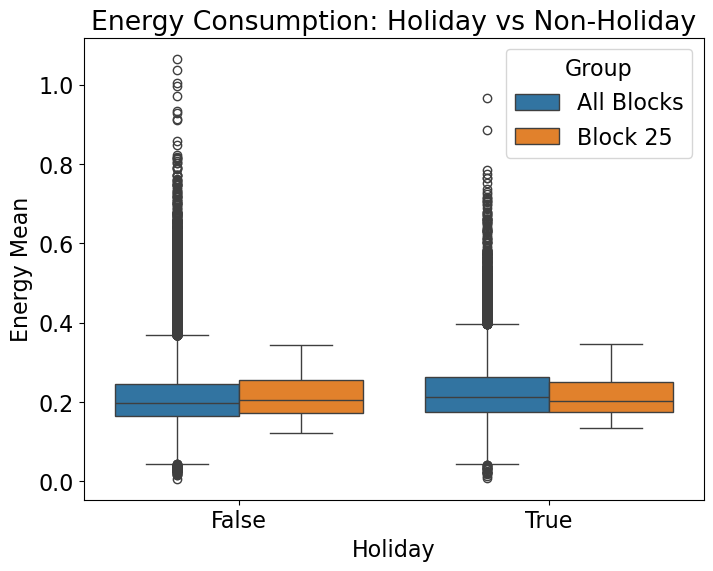

In [114]:
# Add group labels
df_block["Group"] = "All Blocks"
df_filtered = df_block[df_block["block_number"] == filtered_block].copy()
df_filtered["Group"] = f"Block {filtered_block}"

# Combine both datasets
df_combined = pd.concat([df_block, df_filtered])

# Plot with hue to distinguish groups
plt.figure(figsize=(8,6))
sns.boxplot(data=df_combined, x="is_holiday", y="energy_mean", hue="Group")

plt.title("Energy Consumption: Holiday vs Non-Holiday")
plt.xlabel("Holiday")
plt.ylabel("Energy Mean")
plt.legend(title="Group")
plt.show()

Holidays also appear to have no significant effect on consumption.
# Autocorrelation and Partial Autocorrelation Analysis
### Autocorrelation Function (ACF)
Plotted with 400 lags to detect repeating patterns and long-term dependencies. Vertical red dashed lines highlight seasonal lags at 90-day intervals (e.g., quarterly cycles).
### Partial Autocorrelation Function (PACF)
Plotted with 60 lags to identify direct short-term dependencies. Green dashed lines mark weekly intervals.

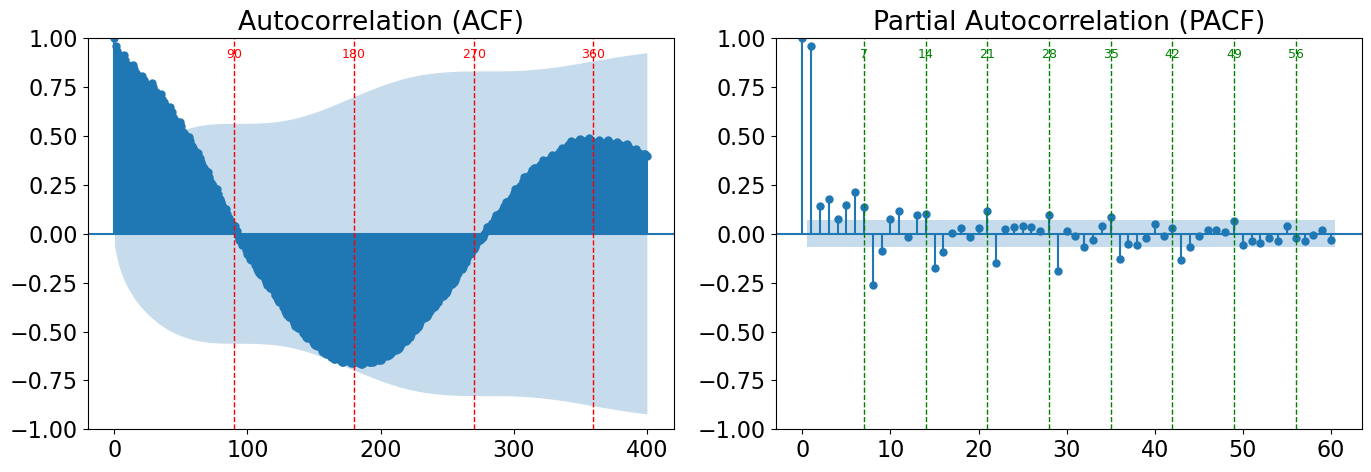

In [115]:
# Suppose df_block has daily data
series = df_block.groupby("day")["energy_mean"].mean()

# Plot ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(series, lags=400, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")
for lag in [90, 180, 270, 360]:
    axes[0].axvline(x=lag, color="red", linestyle="--", linewidth=1)
    axes[0].text(lag, 0.95, f"{lag}", color="red", ha="center", va="top", fontsize=9)

# PACF plot
plot_pacf(series, lags=60, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")
for lag in [7, 14, 21, 28, 35, 42, 49, 56]:
    axes[1].axvline(x=lag, color="green", linestyle="--", linewidth=1)
    axes[1].text(lag, 0.95, f"{lag}", color="green", ha="center", va="top", fontsize=9)

plt.tight_layout()
plt.show()


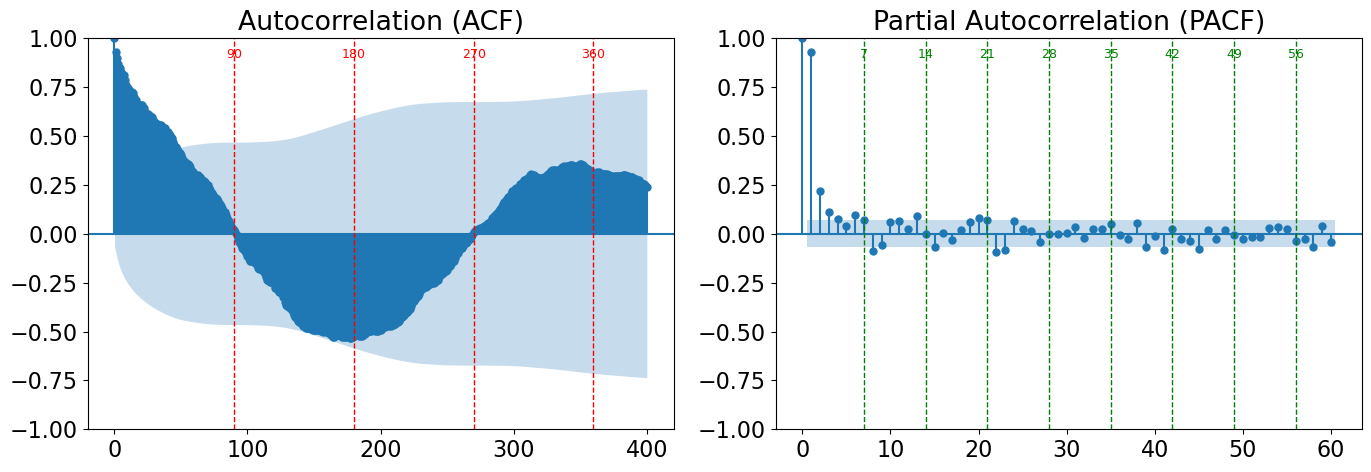

In [116]:
# Suppose df_block has daily data
series = df_block[df_block["block_number"] == filtered_block].groupby("day")["energy_mean"].mean()

# Plot ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(series, lags=400, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")
for lag in [90, 180, 270, 360]:
    axes[0].axvline(x=lag, color="red", linestyle="--", linewidth=1)
    axes[0].text(lag, 0.95, f"{lag}", color="red", ha="center", va="top", fontsize=9)

# PACF plot
plot_pacf(series, lags=60, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")
for lag in [7, 14, 21, 28, 35, 42, 49, 56]:
    axes[1].axvline(x=lag, color="green", linestyle="--", linewidth=1)
    axes[1].text(lag, 0.95, f"{lag}", color="green", ha="center", va="top", fontsize=9)

plt.tight_layout()
plt.show()


We can see seasonal autocorrelation and strong partial autocorrelation with previous day.
# Energy Consumption Trends by Block and House

In [117]:
def plot_energy_curves(df, ids, id_type="block", title=None):
    """
    Plots energy_mean vs day for multiple blocks or houses.

    Parameters:
    - df: DataFrame containing 'day', 'energy_mean', and either 'block_number' or 'LCLid'
    - ids: List of block_numbers or LCLids to plot
    - id_type: 'block' or 'house' to specify which ID type is used
    - title: Optional custom title
    """
    plt.figure(figsize=(15, 6))

    for i, item_id in enumerate(ids):
        if id_type == "block":
            data = df[df["block_number"] == item_id]
            label = f"Block {item_id}"
        elif id_type == "house":
            data = df[df["LCLid"] == item_id]
            label = f"House {item_id}"
        else:
            raise ValueError("id_type must be either 'block' or 'house'")

        if data.empty:
            print(f"⚠️ {label} not found in data.")
            continue

        plt.plot(
            pd.to_datetime(data["day"]),
            data["energy_mean"],
            label=label,
            linewidth=2
        )

    plt.xlabel("Day")
    plt.ylabel("Energy Mean")
    plt.title(title or f"Energy Mean Comparison by {id_type.capitalize()}")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


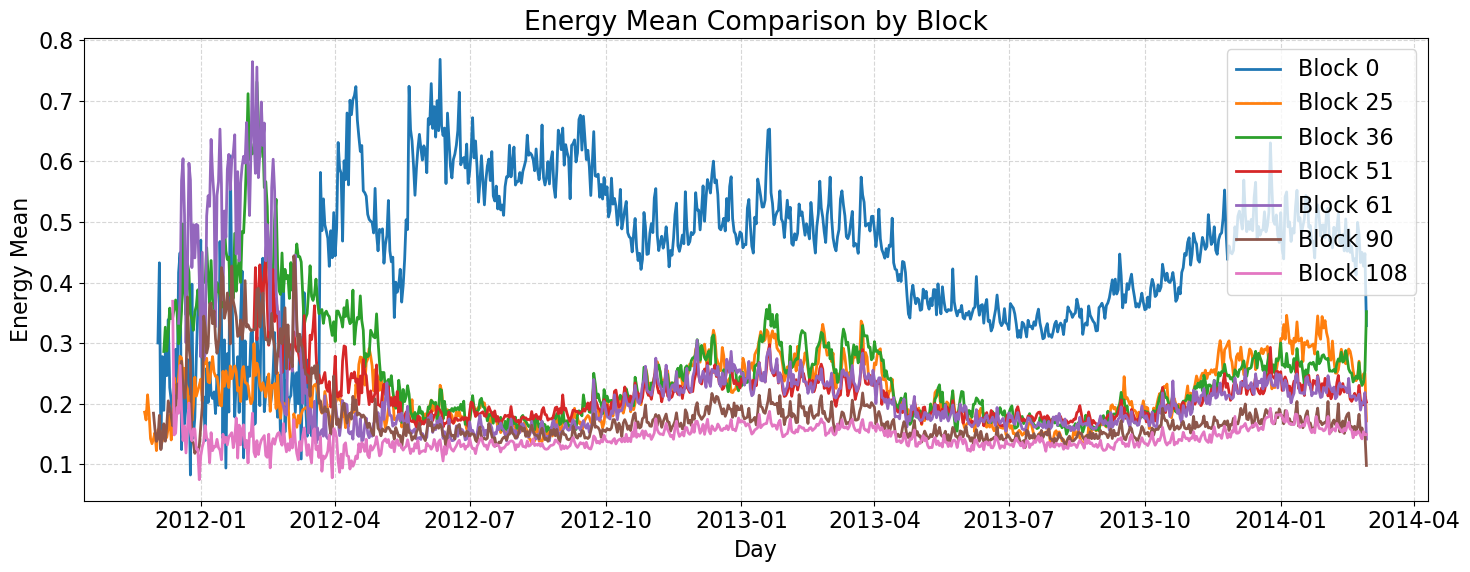

In [118]:
plot_energy_curves(df_block, ids=[0, 25, 36, 51, 61, 90, 108], id_type="block")

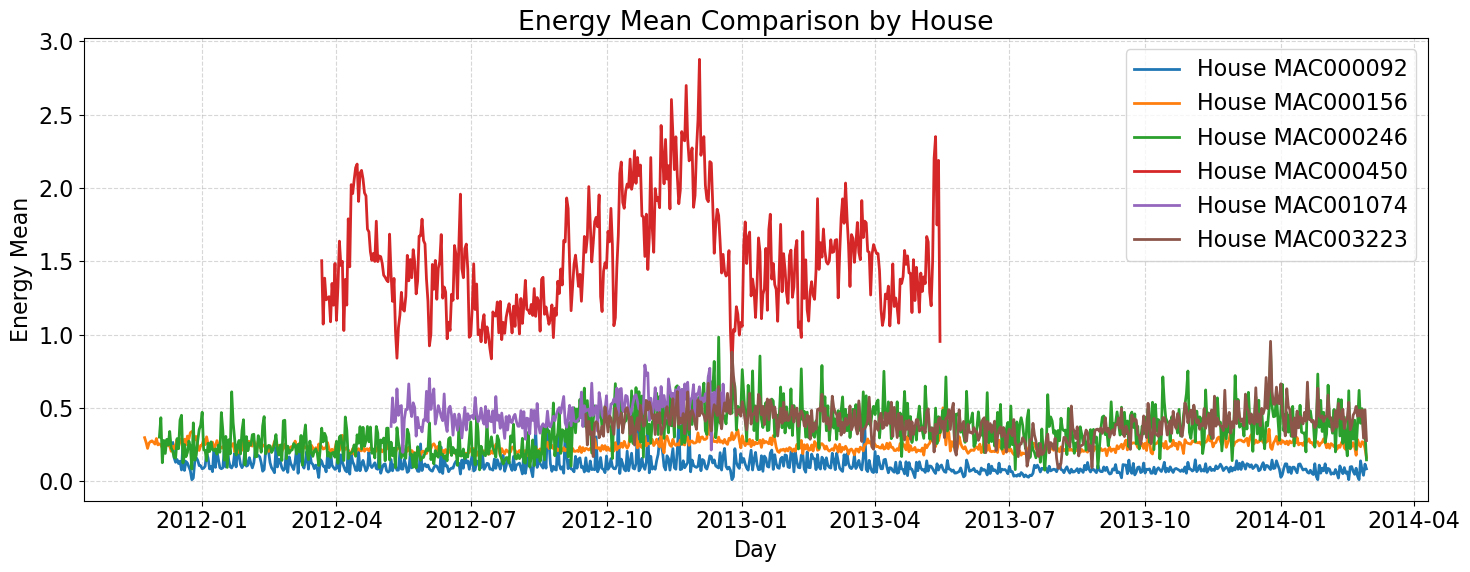

In [119]:
plot_energy_curves(df_house, ids=['MAC000092', 'MAC000156', 'MAC000246', 'MAC000450', 'MAC001074', 'MAC003223'], id_type="house")